In [ ]:
# Command for Google Colab
!gsutil -m cp -r "gs://butqdb-1.0.0.physionet.org" "."
!mv "/content/butqdb-1.0.0.physionet.org" "/content/aura-data"
!ln -s "/content/aura-data" "../aura-data"

In [ ]:
# Install package 
!pip install scaleogram wfdb mat4py

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as GridSpec
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tensorflow import keras
import pywt
import scaleogram as scg 
from mat4py import loadmat
from scipy.fftpack import fft, ifft
import wfdb
import re
from math import *
#from tqdm import tqdm
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import time
import sys

# Read source for create a dataset of annotations
As inputs we have : 
- Signal frequence is 1000Hz so we have 1000 records per seconds
- 18 patients with 24H records per patient
- df_data : signal records data from .dat file (list of 90 millions records)
- df_annotation : labels quality class from .csv file (1, 2 or 3; 0 means the quality was not annotated in this segment) 
- Source : https://physionet.org/content/butqdb/1.0.0/

-> At first step, we will take we will take data only from the 111001 patient which seems to have the best balance of data in each class

## Analysis with patient 111001

- The frequence is 1000Hz, so we have 1000 records per seconds
- We choice to split the dataset in 2 seconds partitions and set
- So the dataset will have 2000 features which is the value of the signal in period of 2 seconds
- The 2001 features of our dataset will be the label of our signal (value extract from the final label feature in the annotation file)
- In order to low the data loaded in RAM and speed the model training, we will reduce the signal length frequence from 1000Hz to 250Hz (so to take one 1 in 4, we will check after if this method doesn't bias the model training)

In [4]:
# See annotation file for patient 111001
# For now, we just considere the 3 last columns : 
#   - the start and end columns which is the interval (in ms) in which the signal was labelized
#   - the class which is the signal label
header_list = ["start1", "end1", "class1","start2", "end2", "class2","start3", "end3", "class3","start", "end", "class"]
df_csv = pd.read_csv("../aura-data/111001/111001_ANN.csv", names=header_list)
df_csv = df_csv[df_csv["class"].notnull() & df_csv["start"].notnull() & df_csv["end"].notnull()]
df_csv.head()


,start1,end1,class1,start2,end2,class2,start3,end3,class3,start,end,class
0,1.0,4315694.0,2.0,1.0,411254.0,2.0,1,7523,1,1.0,415143.0,2.0
1,4315695.0,4334794.0,1.0,411255.0,421291.0,1.0,7524,16977,2,415144.0,421291.0,1.0
2,4334795.0,7908996.0,2.0,421292.0,433271.0,2.0,16978,18848,1,421292.0,433515.0,2.0
3,7908997.0,7915643.0,1.0,433272.0,447315.0,1.0,18849,105566,2,433516.0,447315.0,1.0
4,7915644.0,13719093.0,2.0,447316.0,451027.0,2.0,105567,108563,1,447316.0,451027.0,2.0


In [5]:
# Create list with class label for each range of 2000 records
alist=[]
for i in range(0,len(df_csv)):
    if int(df_csv.end[i]) > len(alist)*2000:
        #print(i)
        for ii in range(0, (int(df_csv.end[i])-len(alist)*2000)//2000):
            alist.append(df_csv["class"][i])

In [6]:
# Have a look of the balance of values for each class
pd.DataFrame(alist).value_counts()

2.0    24308
1.0    19011
3.0     2003
dtype: int64

In [7]:
# Import records and reshape it to array matrix with 2000 features 
# Import all data in array
arr_data_2000 = wfdb.rdrecord("../aura-data/111001/111001_ECG")
arr_data_2000 = arr_data_2000.adc()
arr_data_2000.shape

(90645000, 1)

In [109]:
arr_data_2000[:2000][-5:]

array([[13574],
       [13569],
       [13571],
       [13584],
       [13604]])

In [8]:
# Reshape vector data into a Matrix
# We need to crop the our array data to 90644000 in order it can be devided by 2000 and reshape funciton works
arr_data_2000 = arr_data_2000[:90644000].reshape(arr_data_2000[:90644000].shape[0]//2000,2000)

In [9]:
arr_data_2000.shape

(45322, 2000)

In [10]:
# Check if the reshape was done well in the last values of the first array
arr_data_2000[0][-5:]

array([13574, 13569, 13571, 13584, 13604])

In [11]:
# Concatenate data array matrix with label column vector array
arr_data_2000 = np.concatenate((arr_data_2000,np.array(alist).reshape(len(alist),1)), axis=1)


In [12]:
arr_data_2000.shape

(45322, 2001)

In [13]:
# Show the class balance again
len(arr_data_2000[arr_data_2000[:,2000]==1]), len(arr_data_2000[arr_data_2000[:,2000]==2]), len(arr_data_2000[arr_data_2000[:,2000]==3]) 


(19011, 24308, 2003)

In [14]:
# Order the array by class 
# Create a dataframe pandas from data numpy array
df_data_2000 = pd.DataFrame(arr_data_2000)

In [15]:
df_data_2000.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
0,21753.0,21748.0,21770.0,21788.0,21789.0,21799.0,21793.0,21783.0,21789.0,21791.0,21775.0,21740.0,21724.0,21698.0,21672.0,21674.0,21671.0,21668.0,21667.0,21660.0,21650.0,21659.0,21662.0,21662.0,21678.0,...,13677.0,13683.0,13677.0,13662.0,13669.0,13655.0,13644.0,13653.0,13654.0,13657.0,13653.0,13634.0,13628.0,13640.0,13627.0,13593.0,13582.0,13593.0,13590.0,13574.0,13569.0,13571.0,13584.0,13604.0,2.0
1,13610.0,13594.0,13592.0,13594.0,13609.0,13628.0,13620.0,13600.0,13597.0,13586.0,13565.0,13555.0,13553.0,13543.0,13532.0,13530.0,13521.0,13511.0,13511.0,13515.0,13509.0,13499.0,13519.0,13533.0,13534.0,...,8048.0,8041.0,8032.0,8032.0,8030.0,8014.0,8005.0,8009.0,8018.0,8007.0,7987.0,7982.0,7983.0,7996.0,7994.0,7997.0,7997.0,7992.0,8000.0,8009.0,8001.0,7996.0,7993.0,7986.0,2.0
2,7989.0,7982.0,7984.0,8008.0,8030.0,8039.0,8049.0,8034.0,8017.0,8021.0,8021.0,8014.0,8015.0,8013.0,8010.0,8019.0,8025.0,8030.0,8041.0,8042.0,8026.0,8022.0,8037.0,8027.0,8012.0,...,4880.0,4892.0,4891.0,4891.0,4876.0,4856.0,4852.0,4869.0,4884.0,4890.0,4868.0,4838.0,4833.0,4832.0,4828.0,4840.0,4866.0,4874.0,4864.0,4868.0,4881.0,4873.0,4866.0,4866.0,2.0
3,4863.0,4860.0,4852.0,4844.0,4842.0,4846.0,4851.0,4851.0,4846.0,4832.0,4823.0,4830.0,4837.0,4833.0,4829.0,4838.0,4853.0,4849.0,4840.0,4831.0,4826.0,4836.0,4852.0,4856.0,4843.0,...,2803.0,2802.0,2806.0,2818.0,2810.0,2804.0,2800.0,2795.0,2799.0,2807.0,2815.0,2810.0,2800.0,2788.0,2774.0,2764.0,2756.0,2748.0,2752.0,2752.0,2744.0,2740.0,2732.0,2723.0,2.0
4,2715.0,2720.0,2721.0,2725.0,2736.0,2743.0,2741.0,2728.0,2720.0,2706.0,2684.0,2651.0,2611.0,2589.0,2596.0,2619.0,2650.0,2684.0,2712.0,2735.0,2753.0,2765.0,2786.0,2792.0,2785.0,...,2059.0,2082.0,2091.0,2078.0,2063.0,2065.0,2060.0,2041.0,2025.0,1989.0,1950.0,1904.0,1871.0,1860.0,1860.0,1868.0,1870.0,1872.0,1884.0,1882.0,1854.0,1822.0,1809.0,1792.0,2.0


In [16]:
# Order dataframe by columns and transform it to np array
arr_data_2000 = df_data_2000.sort_values(by=[2000]).values
arr_data_2000.shape

(45322, 2001)

In [612]:
# Store dataframe in CSV file
# df_data_labels.to_csv("data_111001.csv")

In [47]:
# We filter 19011 first datas that are labelized class 1
arr_class_1 = arr_data_2000[:19011][:,:2000][:,:2000:8]
arr_class_1 = arr_class_1/1000
arr_class_1

array([[-0.159, -0.167, -0.172, ...,  0.005,  0.003, -0.006],
       [-0.055, -0.059, -0.077, ..., -0.048, -0.043, -0.046],
       [-0.338, -0.334, -0.334, ..., -0.437, -0.436, -0.441],
       ...,
       [-0.166, -0.164, -0.16 , ...,  0.337,  0.344,  0.359],
       [ 0.084,  0.107,  0.11 , ..., -0.071, -0.072, -0.075],
       [ 0.388,  0.373,  0.379, ...,  0.201,  0.191,  0.185]])

In [48]:
arr_class_1.shape

(19011, 250)

In [49]:
arr_class_2 = arr_data_2000[19011:19011+24308][:,:2000][:,:2000:8]
arr_class_2 = arr_class_2/1000
arr_class_2

array([[-4.450e-01, -4.120e-01, -3.770e-01, ...,  6.000e-02, -4.250e-01,
        -7.030e-01],
       [-3.530e-01, -3.310e-01, -3.000e-02, ..., -1.960e-01, -4.330e-01,
        -3.330e-01],
       [-4.000e-02, -6.700e-02, -6.900e-02, ...,  1.400e-02, -1.500e-02,
         1.000e-03],
       ...,
       [ 1.260e-01,  1.270e-01,  1.200e-01, ..., -5.060e-01, -5.060e-01,
        -5.110e-01],
       [ 1.351e+00,  1.345e+00,  1.344e+00, ...,  3.740e-01,  2.990e-01,
         2.650e-01],
       [ 1.780e-01,  1.600e-01,  1.360e-01, ...,  2.570e-01,  2.550e-01,
         2.330e-01]])

In [50]:
arr_class_3 = arr_data_2000[19011+24308:19011+24308+2003][:,:2000][:,:2000:8]
arr_class_3 = arr_class_3/1000
arr_class_3

array([[ 0.179,  0.186,  0.195, ..., -1.887, -1.359,  0.265],
       [-1.402, -1.42 , -1.634, ..., -1.745, -1.806, -1.905],
       [-0.361, -0.362, -0.366, ..., -0.044, -0.402, -0.648],
       ...,
       [ 0.024,  0.042,  0.049, ..., -0.041, -0.049, -0.01 ],
       [ 0.129,  0.027, -0.068, ..., -0.257, -0.26 , -0.253],
       [-0.121, -0.096, -0.095, ...,  0.087,  0.077,  0.071]])

## Wavelet Transformation & Scaleogram

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


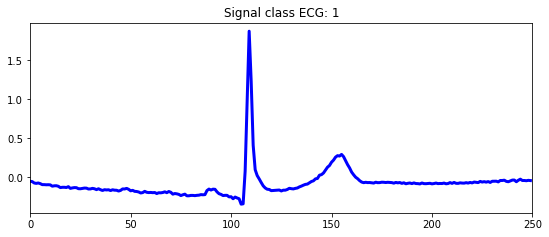

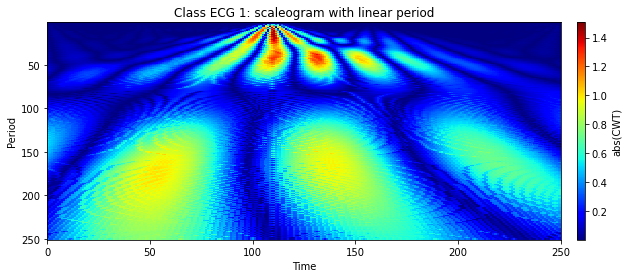

In [59]:
# Display Scaleogram of signal labelled in class 1
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = 1
data = arr_class_1[nn]
label = 1

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")
    

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


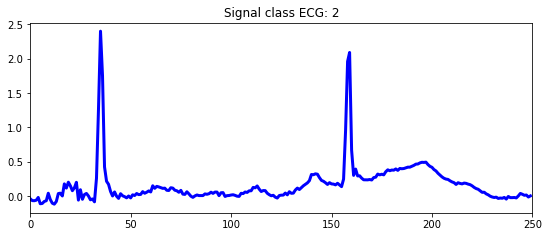

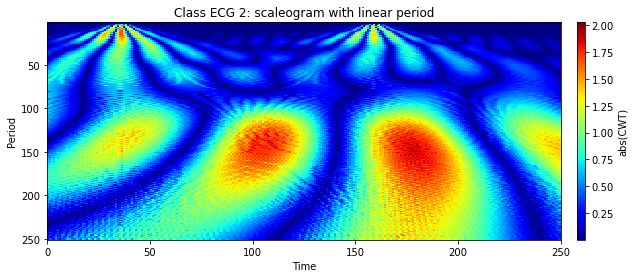

In [60]:
# Display Scaleogram of signal labelled in class 2
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = 2
data = arr_class_2[nn]
label = 2

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

Default wavelet function used to compute the transform: morl ( Morlet wavelet )


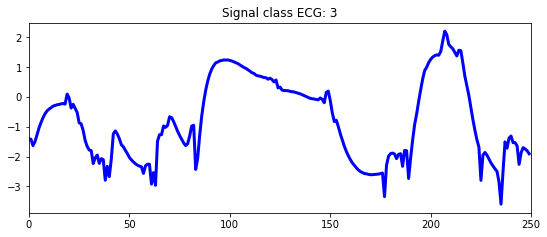

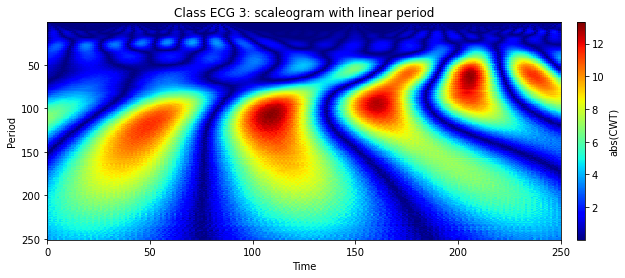

In [62]:
# Display Scaleogram of signal labelled in class 3
# choose default wavelet function 
scg.set_default_wavelet('morl')

# Choice 5 random values in the array indice range
# alist = np.random.choice(range(len(ecg_data_111001)),5)
nn = 1
data = arr_class_3[nn]
label = 3

# Display signal & his scaleogram for each index
signal_length = 250
# range of scales to perform the transform
scales = scg.periods2scales( np.arange(1, signal_length+1) )
x_values_wvt_arr = range(0,len(data),1)

# plot the signal 
fig1, ax1 = plt.subplots(1, 1, figsize=(9, 3.5));  
ax1.plot(x_values_wvt_arr, data, linewidth=3, color='blue')
ax1.set_xlim(0, signal_length)
ax1.set_title(f"Signal class ECG: {label}")

# the scaleogram
scg.cws(data[:signal_length], scales=scales, figsize=(10, 4.0), coi = False, ylabel="Period", xlabel="Time",
        title=f"Class ECG {label}: scaleogram with linear period"); 

print("Default wavelet function used to compute the transform:", scg.get_default_wavelet(), "(",
      pywt.ContinuousWavelet(scg.get_default_wavelet()).family_name, ")")

# Classification

## Test NN with 1000 values signal

In [63]:
# Convert array into list to train our model
arr_class_1_flatten = list(arr_class_1)
arr_class_2_flatten = list(arr_class_2)
arr_class_3_flatten = list(arr_class_3)

In [64]:
# Display list and array dimension for class 1
len(arr_class_1_flatten), len(arr_class_1_flatten[0])

(19011, 250)

In [65]:
#len(arr_class_1_flatten), len(arr_class_2_flatten), len(arr_class_3_flatten)

In [66]:
# Reduce samples data for each class to reduce_size
reduce_size = 1000
full_1500 = (arr_class_1_flatten[0:reduce_size] + arr_class_2_flatten[0:reduce_size] + arr_class_3_flatten[0:reduce_size])


In [67]:
# create the data set with scaleogramme image for each signal data
# We create a X_full 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

start_time = time.time()

fs = len(full_1500[0])
# sgn_length = 1000   #65536   Pay atention with ram memory! 
size_dataset = len(full_1500)
scales = range(1, fs)
waveletname = 'morl'
 
X_full = np.ndarray(shape=(size_dataset, fs-1, fs-1, 3))
                 
for i in tqdm(range(0, size_dataset)):
    if i % 500 == 0:
        print (i, 'done!')
    for j in range(0, 3):
        signal = full_1500[i]
        coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        X_full[i, :, :, j] = coeff[:,:fs-1]

end_time = time.time()

print(f"Time spent : {end_time - start_time} seconds")

0 done!
500 done!
1000 done!
1500 done!
2000 done!
2500 done!

Time spent : 352.70246720314026 seconds


In [40]:
X_full.shape

(3000, 249, 249, 3)

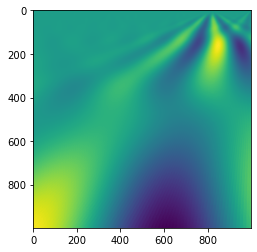

In [91]:
plt.imshow(X_full[0, :, :, 0])

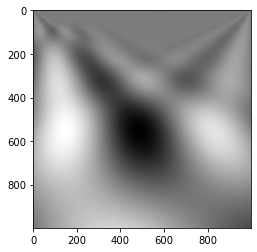

In [134]:
plt.imshow(X_full[1, :, :, 0], cmap="gray")

In [68]:
list_labels_class_1 = ['1']*reduce_size 
list_labels_class_2 = ['2']*reduce_size 
list_labels_class_3 = ['3']*reduce_size 
list_labels = (list_labels_class_1 + list_labels_class_2 + list_labels_class_3)

le = preprocessing.LabelEncoder()
list_labels_encoded = le.fit_transform(list_labels)
X_train, X_test, y_train, y_test = train_test_split(X_full, list_labels_encoded, test_size=0.25, random_state=42)


In [257]:
list_labels_encoded

array([0, 0, 0, ..., 2, 2, 2])

In [42]:
X_train.shape

(2250, 249, 249, 3)

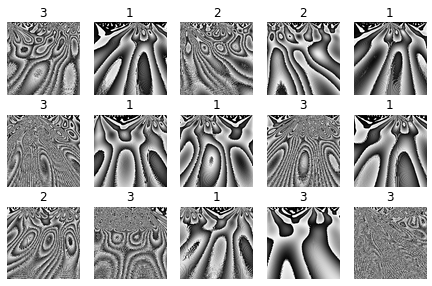

In [69]:
#Inspecting DATA that we will give as input for the model
n_rows = 3
n_cols = 5
class_names = ['1', '2', '3']
plt.figure(figsize=(n_cols*1.5, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_train[index]*255).astype(np.uint8), cmap="binary", interpolation="spline36")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.show()

In [70]:
# Defining basic NN
num_filter, num_classes = 3, 3
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[fs-1, fs-1, num_filter]),
    keras.layers.Dense(1028, activation="relu"),
    #keras.layers.Dense(600, activation="relu"),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dense(300, activation="relu"),                 
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(num_classes, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="Adam", metrics=["accuracy"])

In [71]:
# Display model layers and neurones for each layer
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 186003)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1028)              191212112 
_________________________________________________________________
dense_6 (Dense)              (None, 512)               526848    
_________________________________________________________________
dense_7 (Dense)              (None, 300)               153900    
_________________________________________________________________
dense_8 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 303       
Total params: 191,923,263
Trainable params: 191,923,263
Non-trainable params: 0
________________________________________

In [72]:
# Train the model with training and validation data - first try
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
71/71 [==============================] - 72s 1s/step - loss: 61.1521 - accuracy: 0.3960 - val_loss: 34.4233 - val_accuracy: 0.3800
Epoch 2/20
71/71 [==============================] - 60s 849ms/step - loss: 28.0304 - accuracy: 0.3951 - val_loss: 13.0721 - val_accuracy: 0.4080
Epoch 3/20
71/71 [==============================] - 61s 859ms/step - loss: 8.1608 - accuracy: 0.4369 - val_loss: 4.5876 - val_accuracy: 0.5093
Epoch 4/20
71/71 [==============================] - 61s 865ms/step - loss: 3.6794 - accuracy: 0.4782 - val_loss: 3.4229 - val_accuracy: 0.4587
Epoch 5/20
71/71 [==============================] - 59s 826ms/step - loss: 3.7157 - accuracy: 0.5031 - val_loss: 4.6310 - val_accuracy: 0.5467
Epoch 6/20
71/71 [==============================] - 64s 908ms/step - loss: 2.3897 - accuracy: 0.5173 - val_loss: 1.7353 - val_accuracy: 0.4760
Epoch 7/20
71/71 [==============================] - 100s 1s/step - loss: 2.0253 - accuracy: 0.5578 - val_loss: 1.5473 - val_accuracy: 0.4627


In [73]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 4s 170ms/step - loss: 0.8301 - accuracy: 0.6693


[0.8300554752349854, 0.6693333387374878]

In [74]:
model.save('modele_NN') # save modele

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modele_NN/assets


In [80]:
model = keras.models.load_model('modele_NN') # load model 

In [ ]:
# Train the model with training and validation data - Second try (after model saved after 20 epochs)
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
 8/71 [==>...........................] - ETA: 51s - loss: 3.7779 - accuracy: 0.2227

In [75]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel('epochs', size = 16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.savefig('Figure_epochs.png')   
    plt.close()

In [76]:
plot_learning_curves(history)

In [77]:
prediction = model.predict(X_test)
pred_classes = prediction.argmax(axis=1)

In [78]:
# Confusion Matrix With Scikit
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred_classes)
cm_norm =  cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Text(189.2400000000001, 0.5, 'True')

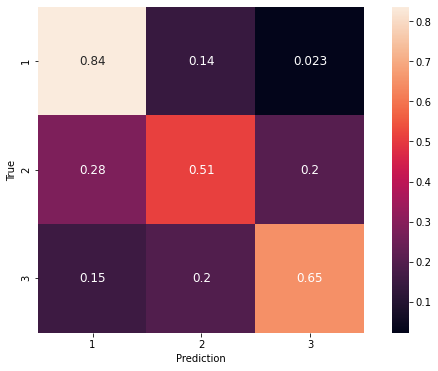

In [79]:
# Ploting Confusion Matrix

df_cm = pd.DataFrame(cm_norm, ['1', '2', '3'], ['1', '2', '3'])
plt.figure(figsize = (10,6))
conf = sns.heatmap(df_cm, annot=True, square=True, annot_kws={"size": 12})
conf.set_xlabel('Prediction')
conf.set_ylabel('True')

## Test CNN

In [336]:
X_train=X_train.values
X_test=X_test.values

In [337]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [755]:
(X_train.shape[1],1)

(30, 1)

In [351]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(3, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    """
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
    """
    history=model.fit(X_train, y_train,epochs=40, batch_size=32,validation_data=(X_test,y_test))
    #model.load_weights('best_model.h5') # ,callbacks=callbacks 
    return(model,history)


In [349]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2','3']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [352]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/40


ValueError: in user code:

    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /Users/henrymacbook/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 3) are incompatible
